In [1]:
import cv2

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader,random_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score
import cv2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------------------
# Transforms (same as feature extraction)
# ----------------------------
normalize = transforms.Normalize((0.5,), (0.5,))

base_transform = transforms.Compose([
    transforms.ToTensor()
])

normalized_transform = transforms.Compose([
    transforms.ToTensor(),
    normalize
])

augment_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(28, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2),
    transforms.ToTensor(),
    normalize
])

transform_variants = {
    "Base": base_transform,
    "Normalized": normalized_transform,
    "Augmented": augment_transform,
    "Regularized": augment_transform
}



In [4]:
# ----------------------------
# Simple CNN class with configurable dropout (dropout only used in classifier)
# ----------------------------
class LeNet(nn.Module):
    def __init__(self, num_classes=10, dropout_prob=0.0):
        super(LeNet, self).__init__()
        
        # Convolutional layers (LeNet-style)
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)   # input: 1x28x28 → 6x28x28
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)                 # → 6x14x14
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1)             # → 16x10x10
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)                 # → 16x5x5

        # Dropout layer (optional)
        self.dropout = nn.Dropout(dropout_prob) if dropout_prob > 0 else nn.Identity()

        # Fully connected layers
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        # Feature extraction
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)

        # Flatten
        x = x.view(x.size(0), -1)

        # Classifier
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x




In [5]:
# ----------------------------
# Training & evaluation helpers
# ----------------------------
def train_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    avg_loss = running_loss / len(loader)
    acc = 100.0 * correct / total
    return avg_loss, acc

def evaluate(model, loader, criterion=None):
    model.eval()
    preds_all, labels_all = [], []
    total_loss = 0.0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1)
            preds_all.extend(preds.cpu().numpy())
            labels_all.extend(labels.cpu().numpy())
            if criterion is not None:
                total_loss += criterion(outputs, labels).item()
    loss = (total_loss / len(loader)) if (criterion is not None) else None
    acc = 100.0 * (np.array(preds_all) == np.array(labels_all)).mean()
    return acc, loss, np.array(preds_all), np.array(labels_all)



In [6]:
# ----------------------------
# Grad-CAM (uses last conv layer conv3)
# ----------------------------
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()
        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_full_backward_hook(backward_hook)

    def generate(self, input_tensor, target_class=None):
        self.model.zero_grad()
        out = self.model(input_tensor)
        if target_class is None:
            target_class = out.argmax(dim=1).item()
        one_hot = torch.zeros_like(out)
        one_hot[0, target_class] = 1
        out.backward(gradient=one_hot, retain_graph=True)

        grads = self.gradients        # BxCxhxw
        acts = self.activations      # BxCxhxw
        weights = grads.mean(dim=(2,3), keepdim=True)  # BxCx1x1
        cam = (weights * acts).sum(dim=1)              # Bxhxw
        cam = F.relu(cam)
        cam = cam.squeeze().cpu().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        return cam, target_class




=== Running variant: Base ===
Epoch [1/10] Train Loss: 0.5555 Train Acc: 82.25% | Val Loss: 0.1899 Val Acc: 94.34%
Epoch [2/10] Train Loss: 0.1477 Train Acc: 95.48% | Val Loss: 0.1100 Val Acc: 96.51%
Epoch [3/10] Train Loss: 0.0966 Train Acc: 97.03% | Val Loss: 0.0724 Val Acc: 97.52%
Epoch [4/10] Train Loss: 0.0758 Train Acc: 97.66% | Val Loss: 0.0519 Val Acc: 98.28%
Epoch [5/10] Train Loss: 0.0626 Train Acc: 98.03% | Val Loss: 0.0497 Val Acc: 98.48%
Epoch [6/10] Train Loss: 0.0542 Train Acc: 98.28% | Val Loss: 0.0548 Val Acc: 98.22%
Epoch [7/10] Train Loss: 0.0476 Train Acc: 98.52% | Val Loss: 0.0476 Val Acc: 98.58%
Epoch [8/10] Train Loss: 0.0435 Train Acc: 98.67% | Val Loss: 0.0407 Val Acc: 98.67%
Epoch [9/10] Train Loss: 0.0383 Train Acc: 98.79% | Val Loss: 0.0392 Val Acc: 98.72%
Epoch [10/10] Train Loss: 0.0355 Train Acc: 98.88% | Val Loss: 0.0394 Val Acc: 98.77%
Final Test Acc: 98.77%  Prec: 0.9877 Rec: 0.9876 F1: 0.9876
Classification report:
               precision    recall 

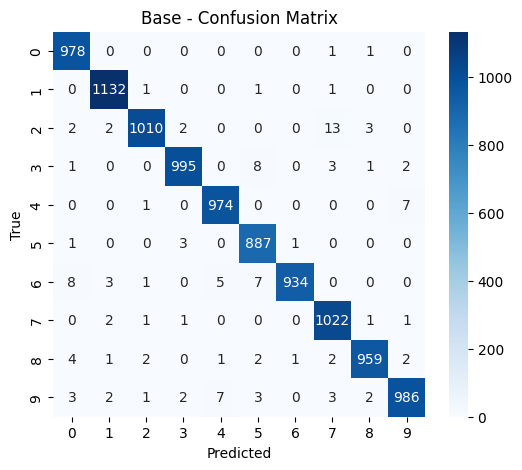

/tmp/ipykernel_3234/2116003155.py:77: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  idx = np.where(np.array(test_ds.targets) == i)[0][0]


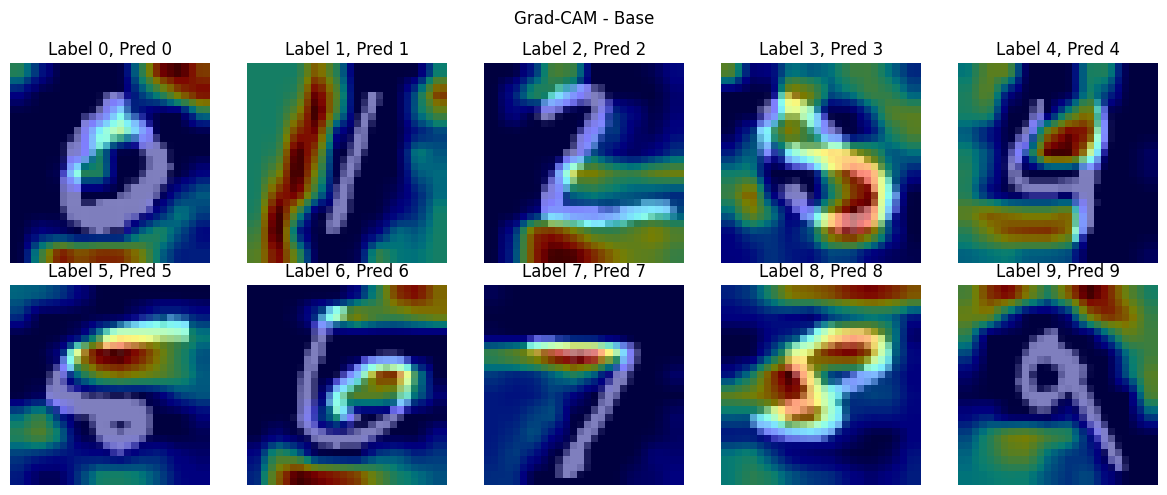


=== Running variant: Normalized ===
Epoch [1/10] Train Loss: 0.5262 Train Acc: 83.02% | Val Loss: 0.1664 Val Acc: 94.90%
Epoch [2/10] Train Loss: 0.1454 Train Acc: 95.51% | Val Loss: 0.1038 Val Acc: 96.79%
Epoch [3/10] Train Loss: 0.1001 Train Acc: 96.91% | Val Loss: 0.0825 Val Acc: 97.20%
Epoch [4/10] Train Loss: 0.0841 Train Acc: 97.38% | Val Loss: 0.0640 Val Acc: 97.61%
Epoch [5/10] Train Loss: 0.0698 Train Acc: 97.81% | Val Loss: 0.0620 Val Acc: 98.10%
Epoch [6/10] Train Loss: 0.0613 Train Acc: 98.04% | Val Loss: 0.0557 Val Acc: 98.27%
Epoch [7/10] Train Loss: 0.0535 Train Acc: 98.26% | Val Loss: 0.0525 Val Acc: 98.28%
Epoch [8/10] Train Loss: 0.0475 Train Acc: 98.52% | Val Loss: 0.0513 Val Acc: 98.38%
Epoch [9/10] Train Loss: 0.0421 Train Acc: 98.69% | Val Loss: 0.0452 Val Acc: 98.60%
Epoch [10/10] Train Loss: 0.0377 Train Acc: 98.80% | Val Loss: 0.0460 Val Acc: 98.46%
Final Test Acc: 98.46%  Prec: 0.9847 Rec: 0.9843 F1: 0.9844
Classification report:
               precision    r

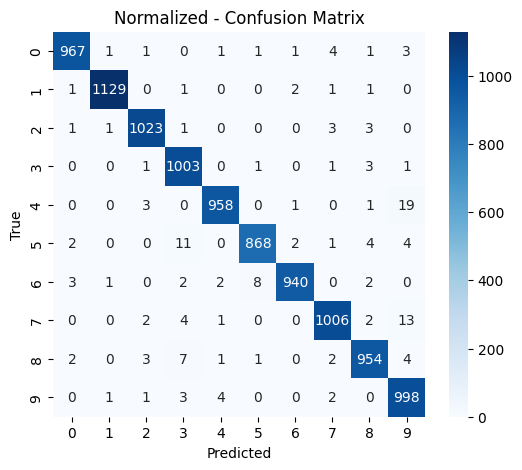

/tmp/ipykernel_3234/2116003155.py:77: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  idx = np.where(np.array(test_ds.targets) == i)[0][0]


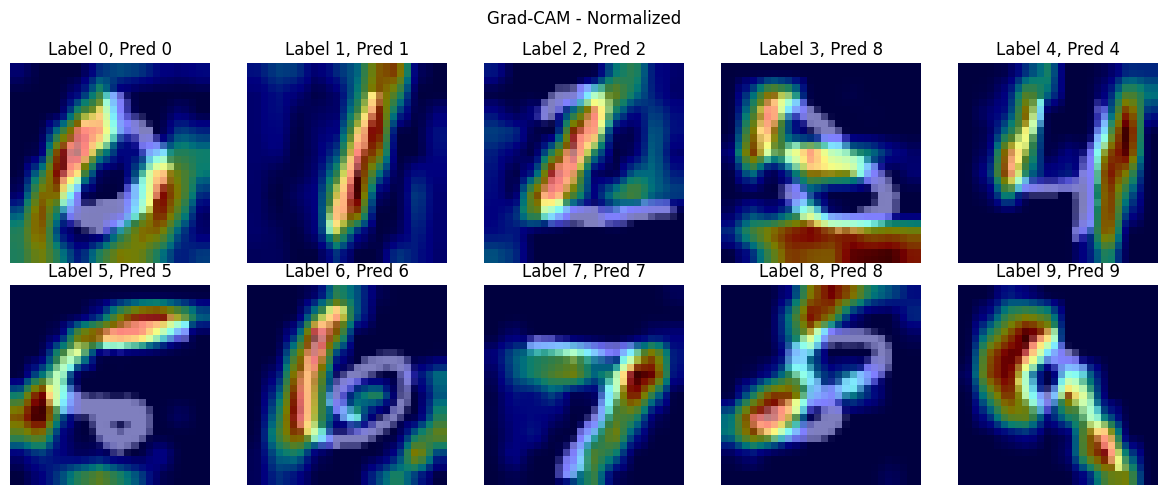


=== Running variant: Augmented ===
Epoch [1/10] Train Loss: 0.8920 Train Acc: 69.55% | Val Loss: 0.3987 Val Acc: 87.23%
Epoch [2/10] Train Loss: 0.3377 Train Acc: 89.28% | Val Loss: 0.2373 Val Acc: 92.43%
Epoch [3/10] Train Loss: 0.2272 Train Acc: 92.84% | Val Loss: 0.1845 Val Acc: 93.87%
Epoch [4/10] Train Loss: 0.1804 Train Acc: 94.31% | Val Loss: 0.1540 Val Acc: 95.05%
Epoch [5/10] Train Loss: 0.1535 Train Acc: 95.14% | Val Loss: 0.1324 Val Acc: 95.64%
Epoch [6/10] Train Loss: 0.1357 Train Acc: 95.74% | Val Loss: 0.1178 Val Acc: 96.12%
Epoch [7/10] Train Loss: 0.1244 Train Acc: 96.08% | Val Loss: 0.1209 Val Acc: 96.18%
Epoch [8/10] Train Loss: 0.1130 Train Acc: 96.47% | Val Loss: 0.1058 Val Acc: 96.50%
Epoch [9/10] Train Loss: 0.1050 Train Acc: 96.68% | Val Loss: 0.0924 Val Acc: 96.92%
Epoch [10/10] Train Loss: 0.0971 Train Acc: 96.85% | Val Loss: 0.0915 Val Acc: 96.98%
Final Test Acc: 97.22%  Prec: 0.9723 Rec: 0.9716 F1: 0.9719
Classification report:
               precision    re

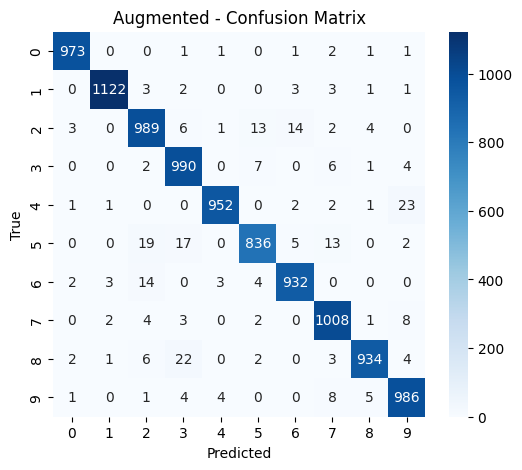

/tmp/ipykernel_3234/2116003155.py:77: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  idx = np.where(np.array(test_ds.targets) == i)[0][0]


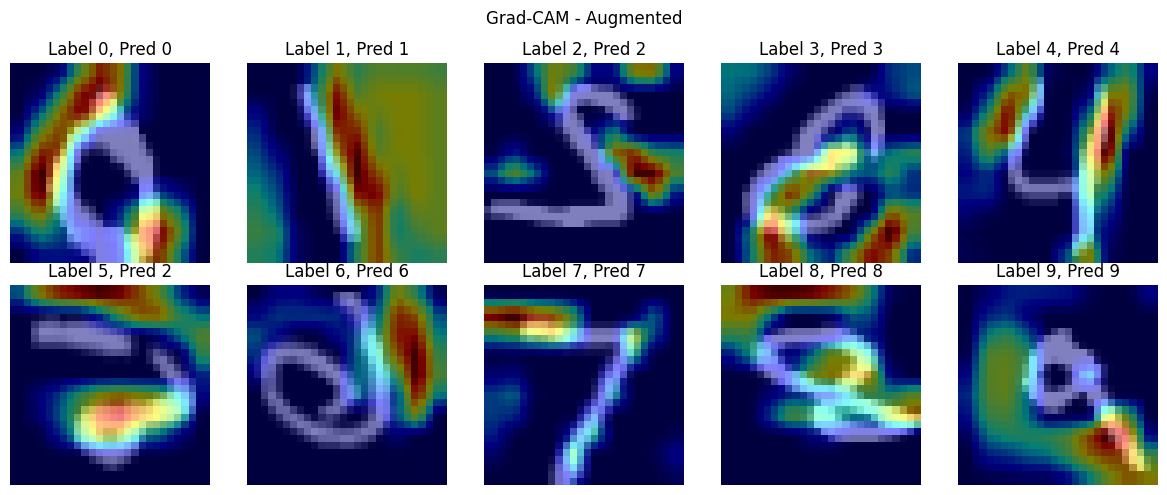


=== Running variant: Regularized ===
Epoch [1/10] Train Loss: 1.1839 Train Acc: 58.88% | Val Loss: 0.5569 Val Acc: 82.17%
Epoch [2/10] Train Loss: 0.6213 Train Acc: 79.43% | Val Loss: 0.3401 Val Acc: 87.84%
Epoch [3/10] Train Loss: 0.4647 Train Acc: 85.33% | Val Loss: 0.2637 Val Acc: 91.81%
Epoch [4/10] Train Loss: 0.3909 Train Acc: 87.97% | Val Loss: 0.2131 Val Acc: 93.23%
Epoch [5/10] Train Loss: 0.3463 Train Acc: 89.53% | Val Loss: 0.1719 Val Acc: 94.72%
Epoch [6/10] Train Loss: 0.3133 Train Acc: 90.77% | Val Loss: 0.1652 Val Acc: 94.87%
Epoch [7/10] Train Loss: 0.2820 Train Acc: 91.80% | Val Loss: 0.1480 Val Acc: 95.26%
Epoch [8/10] Train Loss: 0.2661 Train Acc: 92.37% | Val Loss: 0.1383 Val Acc: 95.81%
Epoch [9/10] Train Loss: 0.2462 Train Acc: 92.86% | Val Loss: 0.1336 Val Acc: 95.85%
Epoch [10/10] Train Loss: 0.2357 Train Acc: 93.19% | Val Loss: 0.1300 Val Acc: 96.09%
Final Test Acc: 96.21%  Prec: 0.9618 Rec: 0.9614 F1: 0.9615
Classification report:
               precision    

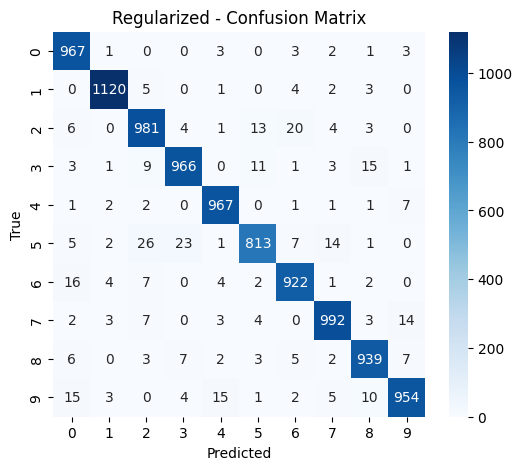

/tmp/ipykernel_3234/2116003155.py:77: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  idx = np.where(np.array(test_ds.targets) == i)[0][0]


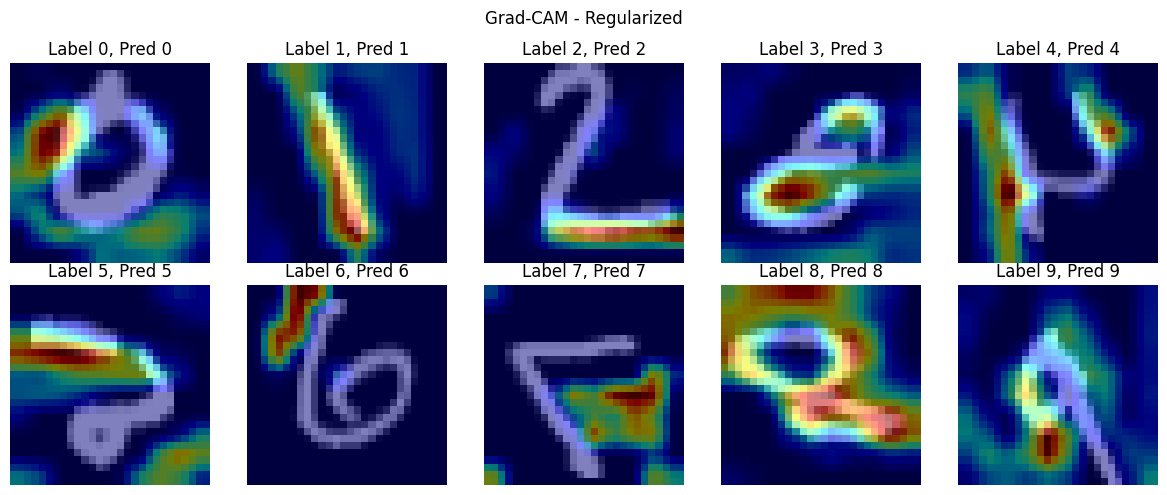

In [7]:
# ----------------------------
# Main loop: training all variations properly (dropout + weight_decay only for Regularized)
# ----------------------------
results = {}
num_epochs = 10
batch_size = 128
criterion = nn.CrossEntropyLoss()

for name, transform in transform_variants.items():
    print(f"\n=== Running variant: {name} ===")
    train_ds = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
    test_ds = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

    # --- Train / Val split ---
    total_train = len(train_ds)
    val_size = int(0.2 * total_train)
    train_size = total_train - val_size

    # deterministic split (optional seed)
    generator = None
    try:
        generator = torch.Generator()
        generator.manual_seed(42)
        train_dataset, val_dataset = random_split(train_ds, [train_size, val_size], generator=generator, )
    except Exception:
        train_dataset, val_dataset = random_split(train_ds, [train_size, val_size])

    # --- DataLoaders ---
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_ds, batch_size=1000, shuffle=False)

    # regularize logic: enable dropout in model and weight decay in optimizer only for 'Regularized'
    is_regularize = (name == "Regularized")
    dropout_prob = 0.5 if is_regularize else 0.0

    model = LeNet(num_classes=10, dropout_prob=dropout_prob).to(device)

    weight_decay = 1e-4 if is_regularize else 0.0
    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=weight_decay)

    # History containers
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    # Train
    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
        val_acc, val_loss, _, _ = evaluate(model, test_loader, criterion)
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {train_loss:.4f} Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f} Val Acc: {val_acc:.2f}%")

    # Final evaluation metrics (detailed)
    test_acc, _, preds, labels = evaluate(model, test_loader)
    prec = precision_score(labels, preds, average='macro')
    rec  = recall_score(labels, preds, average='macro')
    f1   = f1_score(labels, preds, average='macro')
    print(f"Final Test Acc: {test_acc:.2f}%  Prec: {prec:.4f} Rec: {rec:.4f} F1: {f1:.4f}")
    print("Classification report:\n", classification_report(labels, preds, digits=4))

    # Confusion matrix
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # Grad-CAM: visualize one example per class (2x5 grid)
    gradcam = GradCAM(model, model.conv2)
    fig, axes = plt.subplots(2, 5, figsize=(12,5))
    axes_flat = axes.flatten()
    for i in range(10):
        idx = np.where(np.array(test_ds.targets) == i)[0][0]
        img, _ = test_ds[idx]
        inp = img.unsqueeze(0).to(device)
        inp.requires_grad_()
        cam, cls = gradcam.generate(inp)
        cam_resized = cv2.resize(cam, (img.shape[2], img.shape[1]))
        ax = axes_flat[i]
        ax.imshow(img.squeeze().cpu().numpy(), cmap='gray')
        ax.imshow(cam_resized, cmap='jet', alpha=0.5)
        ax.set_title(f"Label {i}, Pred {cls}")
        ax.axis("off")
    plt.suptitle(f"Grad-CAM - {name}")
    plt.tight_layout()
    plt.show()

    # store results
    results[name] = {"history": history, "test_acc": test_acc, "prec": prec, "rec": rec, "f1": f1, "cm": cm}



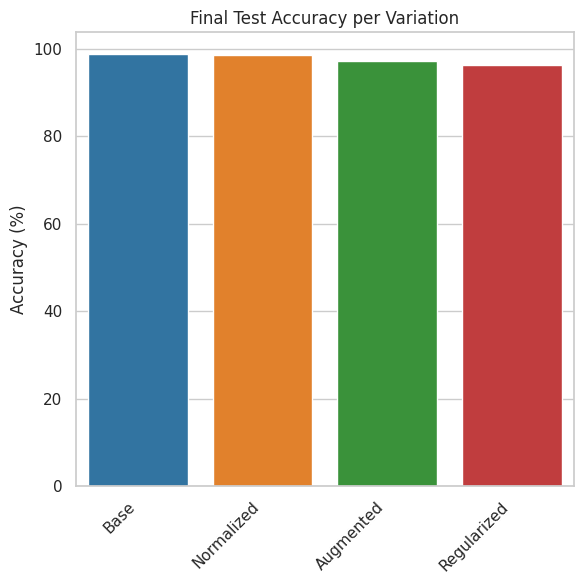

In [8]:
# Summary bar chart (final test accuracy)
import pandas as pd
names = list(results.keys())
accs  = [results[n]["test_acc"] for n in names]
df = pd.DataFrame({
    'Variation': names,
    'Accuracy': accs
})

plt.figure(figsize=(6,6))
sns.set_theme(style="whitegrid")

ax = sns.barplot(
    data=df,
    x='Variation',
    y='Accuracy',
    hue='Variation',
    dodge=False,
    palette='tab10',
    legend=False
)

ax.set_title("Final Test Accuracy per Variation")
ax.set_ylabel("Accuracy (%)")
ax.set_xlabel(None)

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

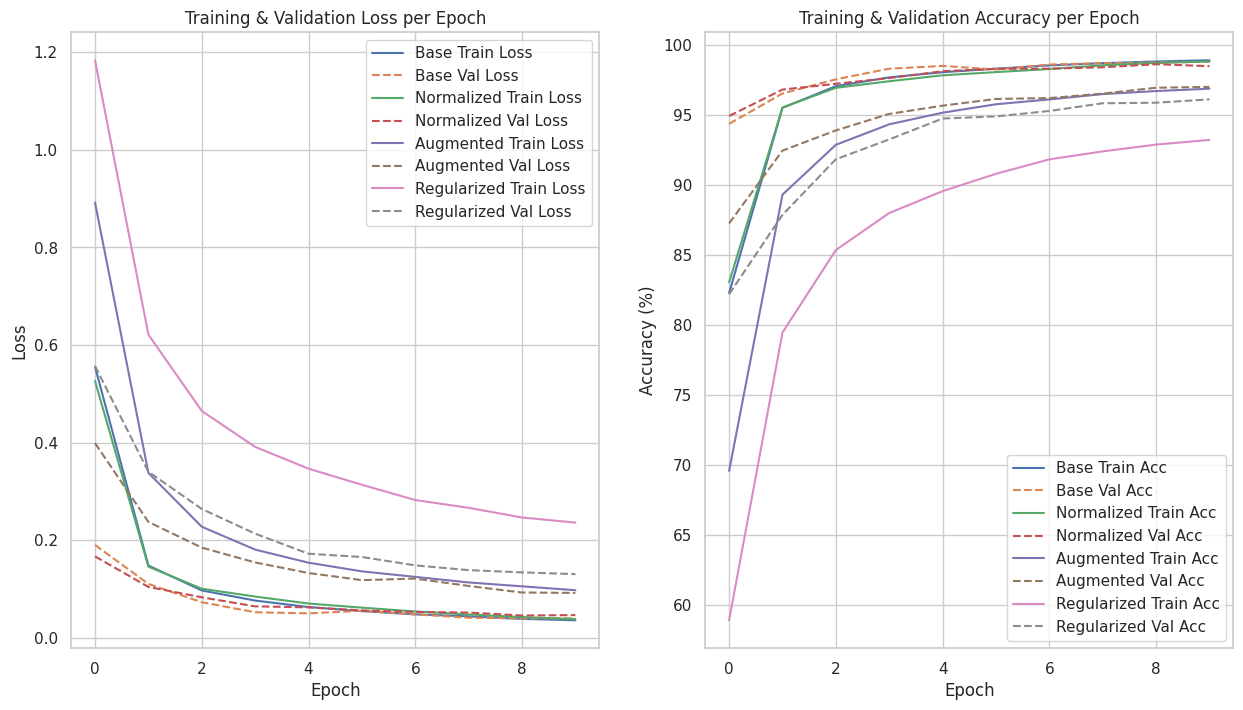

In [9]:
# ----------------------------
# Plot loss & accuracy curves for all variants
# ----------------------------
plt.figure(figsize=(15,8))
plt.subplot(1,2,1)

for name, res in results.items():
    history = res["history"]
    plt.plot(history["train_loss"], label=f"{name} Train Loss")
    plt.plot(history["val_loss"], linestyle="--", label=f"{name} Val Loss")

plt.title("Training & Validation Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
# plt.show()

# Plot accuracy curves
plt.subplot(1,2,2)
for name, res in results.items():
    history = res["history"]
    plt.plot(history["train_acc"], label=f"{name} Train Acc")
    plt.plot(history["val_acc"], linestyle="--", label=f"{name} Val Acc")

plt.title("Training & Validation Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)
plt.show()


In [10]:
import pickle

with open("results_cnnbaseline.pkl", "wb") as f:
    pickle.dump(results, f)


In [11]:
with open("./results_cnnbaseline.pkl", "rb") as f:
    results= pickle.load(f)

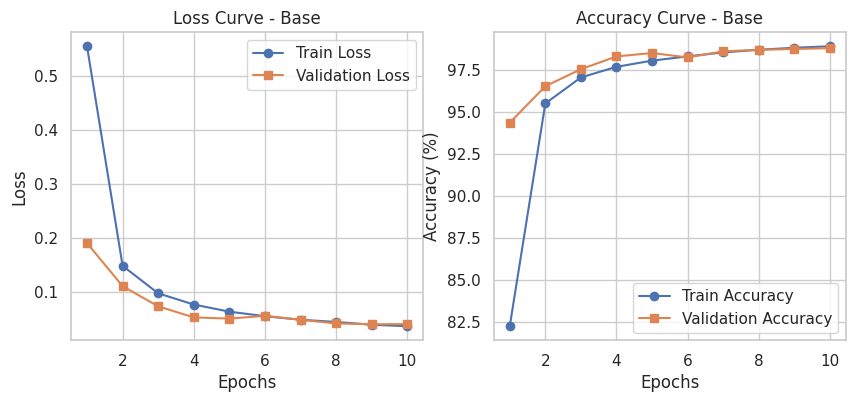

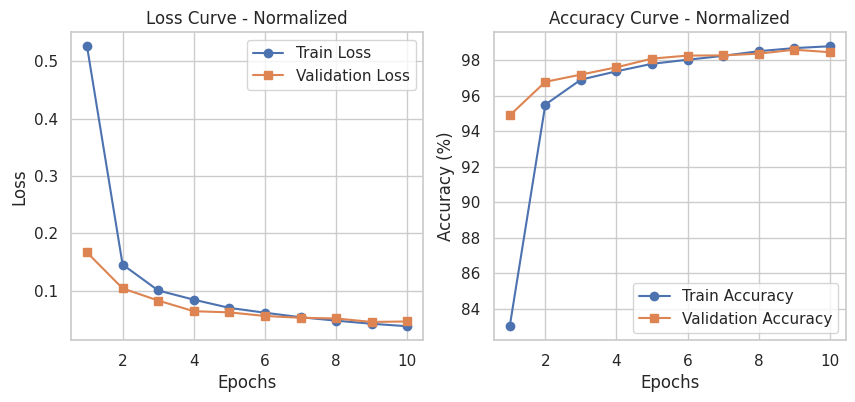

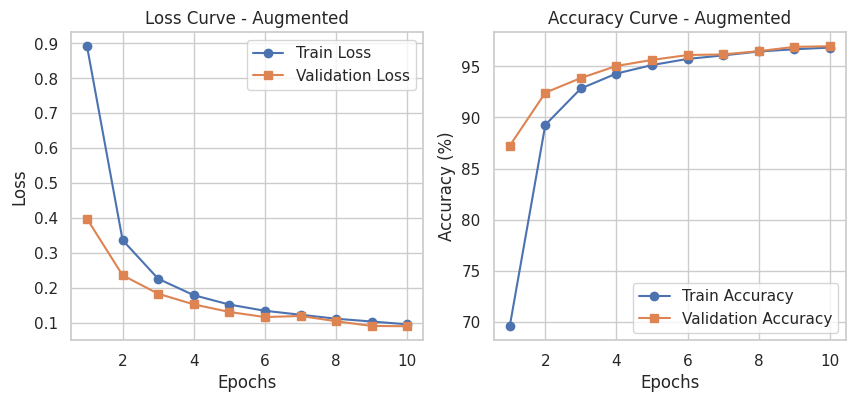

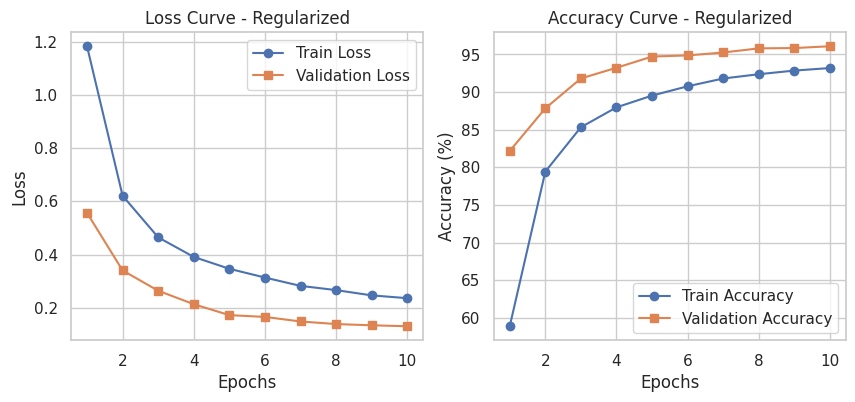

In [12]:
for variation, data in results.items():
    if "history" not in data:
        continue
    
    history = data["history"]
    epochs = range(1, len(history["train_loss"]) + 1)

    # --- LOSS CURVE ---
    plt.figure(figsize=(10, 4))
    plt.subplot(1,2,1)
    plt.plot(epochs, history["train_loss"], label="Train Loss", marker='o')
    plt.plot(epochs, history["val_loss"], label="Validation Loss", marker='s')
    plt.title(f"Loss Curve - {variation}")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    # --- ACCURACY CURVE ---
    plt.subplot(1,2,2)
    plt.plot(epochs, history["train_acc"], label="Train Accuracy", marker='o')
    plt.plot(epochs, [float(v) for v in history["val_acc"]], label="Validation Accuracy", marker='s')
    plt.title(f"Accuracy Curve - {variation}")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.grid(True)
    plt.show()